*import necessary libraries*

In [47]:
import pandas as pd
import sys
import os
import numpy as np

# Import the data

In [124]:
# import the preprocessed vectorized data
train_data = pd.read_csv('data/pre_proc_data/train.txt')
test_data = pd.read_csv('data/pre_proc_data/test.txt')

In [126]:
# count all nan values
print("Train data nan values: ", train_data.isna().sum())
print("Test data nan values: ", test_data.isna().sum())

Train data nan values:  text       0
emotion    0
dtype: int64
Test data nan values:  text       0
emotion    0
dtype: int64


# Optimize the model class

In [168]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


In [177]:
class_labels = ['sadness', 'anger', 'love', 'surprise', 'fear', 'joy']

confusion_matrix_kwargs = dict(
    text_auto=True, 
    title="Confusion Matrix", width=1000, height=800,
    labels=dict(x="Predicted", y="True Label"),
    x=class_labels,
    y=class_labels,
    color_continuous_scale='Blues'
)

class Model:
    def __init__(self, X_train, y_train, X_test, y_test, model_architecture, vectorizer, balancer=None, random_seed=42, test_size=0.2) -> None:
        
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        
        self.model_instance = model_architecture
        self.vectorizer = vectorizer
        self.balancer = balancer
        
        self.random_seed = random_seed
        self.test_size = test_size
    def transform(self):
        # fit transform the data
        self.X_train = self.vectorizer.fit_transform(self.X_train)
        self.X_test = self.vectorizer.transform(self.X_test)

    def fit(self):
        # then balance the data if needed
        if self.balancer:
            self.X_train, self.y_train = self.balancer.fit_resample(self.X_train, self.y_train)
        # then fit the model
        self.model_instance.fit(self.X_train, self.y_train)

    def predict(self):
        return self.model_instance.predict(self.X_test)

    def predict_custom(self, X_test, y_test):
        self.X_test = X_test
        self.y_test = y_test
        self.predict()

    def predict_proba(self):
        return self.model_instance.predict_proba(self.X_test)
    
    def train_and_plot_curves(self):
            # Train the model while recording metrics
            train_sizes, train_scores, test_scores = learning_curve(
                self.model_instance, self.X_train, self.y_train, cv=5,
                train_sizes=np.linspace(0.1, 1.0, 5)  # Vary training data sizes
            )

            # Plot learning curves
            plt.figure(figsize=(10, 6))
            plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Score')
            plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Cross-Validation Score')
            plt.xlabel('Training Examples')
            plt.ylabel('Score')
            plt.legend()
            plt.title('Learning Curves')
            plt.show()
            
    def hyperparameter_tuning(self, param_grid, search_type='grid'):
            if search_type == 'grid':
                search = GridSearchCV(self.model_instance, param_grid, cv=5)
            elif search_type == 'random':
                search = RandomizedSearchCV(self.model_instance, param_distributions=param_grid, n_iter=10, cv=5, random_state=42)
            else:
                raise ValueError("Invalid search_type. Use 'grid' or 'random'.")

            search.fit(self.X_train, self.y_train)
            return search.best_estimator_

    def report(self, y_pred, class_labels):
        print(classification_report(self.y_test, y_pred, target_names=class_labels))
        confusion_matrix_toshow = confusion_matrix(self.y_test, y_pred)
        fig = px.imshow(
            confusion_matrix_toshow, 
            **confusion_matrix_kwargs
            )
        fig.show()

In [137]:
X_train = train_data['text'].values
y_train = train_data['emotion'].values

X_test = test_data['text'].values
y_test = test_data['emotion'].values

In [152]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [178]:
model = Model(X_train, y_train, X_test, y_test, MultinomialNB(), TfidfVectorizer(), balancer=SMOTE(random_state=42))
model.transform()
model.fit()
y_pred = model.predict()
model.report(y_pred, class_labels)

              precision    recall  f1-score   support

     sadness       0.83      0.84      0.83       275
       anger       0.82      0.78      0.80       224
        love       0.90      0.84      0.87       695
    surprise       0.61      0.83      0.71       159
        fear       0.91      0.87      0.89       581
         joy       0.56      0.82      0.67        66

    accuracy                           0.84      2000
   macro avg       0.77      0.83      0.79      2000
weighted avg       0.85      0.84      0.84      2000



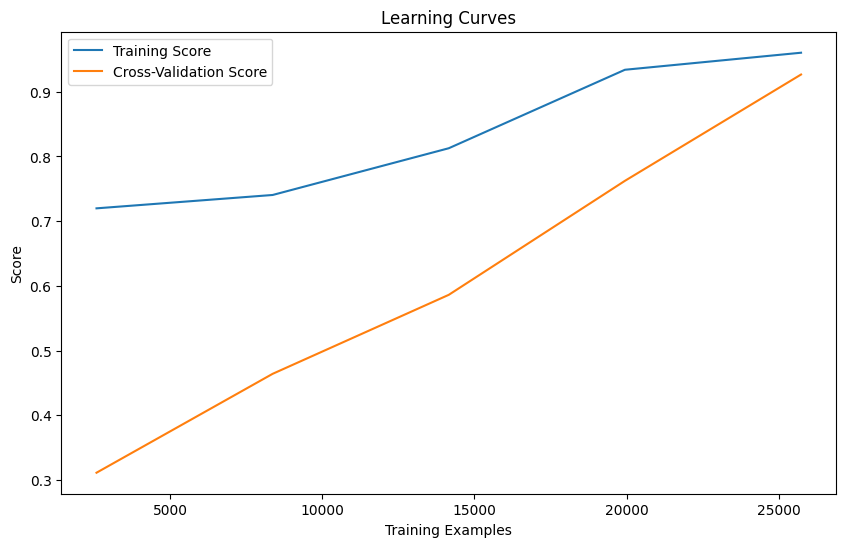

In [179]:
model.train_and_plot_curves()

In [181]:

model = Model(X_train, y_train, X_test, y_test, LogisticRegression(solver='liblinear',random_state = 42), TfidfVectorizer())
model.transform()
model.fit()
y_pred = model.predict()
model.report(y_pred, class_labels)

              precision    recall  f1-score   support

     sadness       0.89      0.83      0.86       275
       anger       0.89      0.77      0.83       224
        love       0.83      0.96      0.89       695
    surprise       0.85      0.59      0.70       159
        fear       0.90      0.93      0.92       581
         joy       0.94      0.47      0.63        66

    accuracy                           0.87      2000
   macro avg       0.88      0.76      0.80      2000
weighted avg       0.87      0.87      0.86      2000



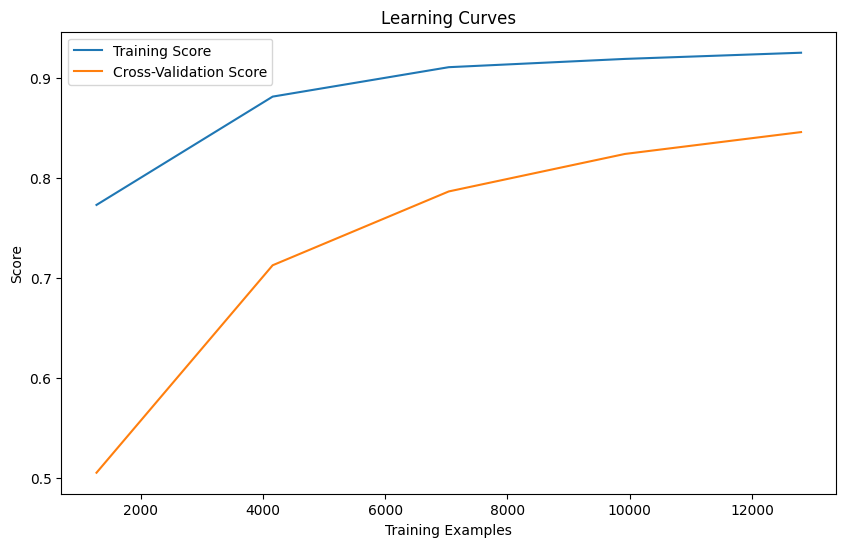

In [182]:
model.train_and_plot_curves()

In [183]:
model = Model(X_train, y_train, X_test, y_test, LogisticRegression(solver='liblinear',random_state = 42), TfidfVectorizer(), balancer=SMOTE(random_state=42))
model.transform()
model.fit()
y_pred = model.predict()
model.report(y_pred, class_labels)

              precision    recall  f1-score   support

     sadness       0.87      0.88      0.87       275
       anger       0.86      0.81      0.84       224
        love       0.94      0.88      0.91       695
    surprise       0.69      0.90      0.78       159
        fear       0.95      0.90      0.92       581
         joy       0.60      0.85      0.70        66

    accuracy                           0.88      2000
   macro avg       0.82      0.87      0.84      2000
weighted avg       0.89      0.88      0.88      2000



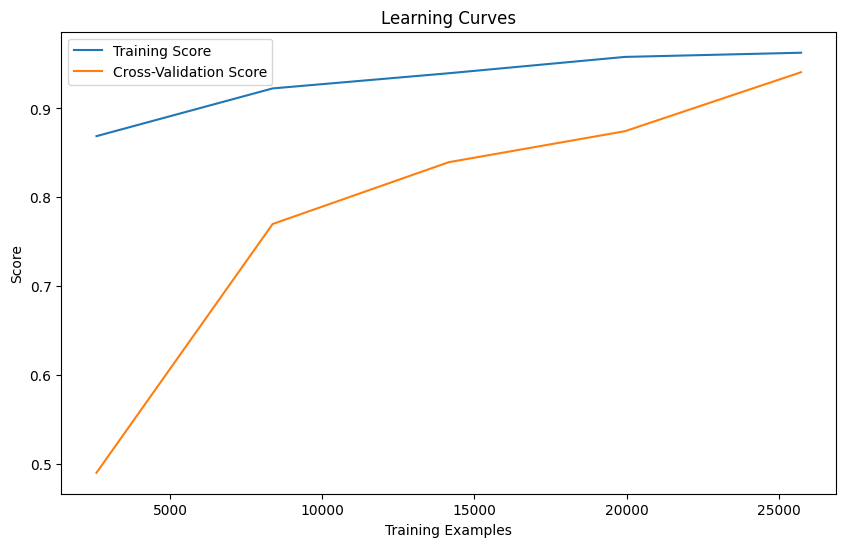

In [184]:
model.train_and_plot_curves()

In [188]:
model = Model(X_train, y_train, X_test, y_test, LogisticRegression(solver='liblinear', random_state=42), TfidfVectorizer(), balancer=SMOTE(random_state=42))
model.transform()

param_grid = {
    'C': [0.001, 0.01, 0.1, 1.0, 10.0],  # regularization parameter
    'penalty': ['l1', 'l2'],  # regularization type
}
best_model = model.hyperparameter_tuning(param_grid, search_type='grid')

c:\Users\antoi\Anaconda3\envs\NPL\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



In [192]:
model = Model(X_train, y_train, X_test, y_test, best_model, TfidfVectorizer(), balancer=SMOTE(random_state=42))
model.transform()
model.fit()
y_pred = model.predict()
model.report(y_pred, class_labels)

              precision    recall  f1-score   support

     sadness       0.87      0.91      0.89       275
       anger       0.87      0.85      0.86       224
        love       0.95      0.89      0.92       695
    surprise       0.71      0.92      0.81       159
        fear       0.97      0.91      0.94       581
         joy       0.60      0.85      0.70        66

    accuracy                           0.90      2000
   macro avg       0.83      0.89      0.85      2000
weighted avg       0.91      0.90      0.90      2000



In [153]:
model = Model(X_train, y_train, X_test, y_test, DecisionTreeClassifier(random_state = 42), TfidfVectorizer(), balancer=SMOTE(random_state=42))
model.fit()
y_pred = model.predict()
model.report(y_pred, class_labels)

              precision    recall  f1-score   support

     sadness       0.85      0.89      0.87       275
       anger       0.82      0.84      0.83       224
        love       0.93      0.85      0.89       695
    surprise       0.70      0.82      0.76       159
        fear       0.91      0.89      0.90       581
         joy       0.60      0.80      0.69        66

    accuracy                           0.86      2000
   macro avg       0.80      0.85      0.82      2000
weighted avg       0.87      0.86      0.87      2000



In [154]:
model = Model(X_train, y_train, X_test, y_test, SVC(random_state = 42), TfidfVectorizer(), balancer=SMOTE(random_state=42))
model.fit()
y_pred = model.predict()
model.report(y_pred, class_labels)

              precision    recall  f1-score   support

     sadness       0.89      0.82      0.85       275
       anger       0.86      0.79      0.82       224
        love       0.83      0.95      0.89       695
    surprise       0.82      0.58      0.68       159
        fear       0.90      0.92      0.91       581
         joy       0.80      0.55      0.65        66

    accuracy                           0.86      2000
   macro avg       0.85      0.77      0.80      2000
weighted avg       0.86      0.86      0.86      2000



In [155]:
model = Model(X_train, y_train, X_test, y_test, RandomForestClassifier(random_state = 42), TfidfVectorizer(), balancer=SMOTE(random_state=42))
model.fit()
y_pred = model.predict()
model.report(y_pred, class_labels)

              precision    recall  f1-score   support

     sadness       0.85      0.90      0.88       275
       anger       0.85      0.86      0.85       224
        love       0.89      0.88      0.89       695
    surprise       0.72      0.81      0.77       159
        fear       0.94      0.87      0.90       581
         joy       0.60      0.71      0.65        66

    accuracy                           0.87      2000
   macro avg       0.81      0.84      0.82      2000
weighted avg       0.87      0.87      0.87      2000

